In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

plt.style.use("seaborn-darkgrid")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Manually generate a dataset

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=0.6, random_state=0)

### Utility Plotting function

In [3]:
def plot(X, y, 
         title="X versus Y", 
         xlabel="X-axis", 
         ylabel="Y-axis", 
         figsize=(10, 8), 
         centers=None):
    
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
    centers = None if centers is None else np.array(centers)

    for ctype in cdict:
        type_idx = np.where(y == ctype)
        plt.scatter(X[type_idx, 0],
                    X[type_idx, 1],
                    c=cdict[ctype],
                    label=ctype,
                    marker='.',
                    s=25)
        
        # plot centers if provided
        if centers is not None:
            plt.text(centers[ctype, 0]+0.1, 
                     centers[ctype, 1]+0.1,
                     f"Centroid {ctype}",
                     fontsize=9,
                    )
            plt.scatter(centers[ctype, 0], 
                        centers[ctype, 1], 
                        c=cdict[ctype],
                        marker='x',
                        s=100)
            
    plt.legend()
    plt.show()

### Plot the blob set with the X labels

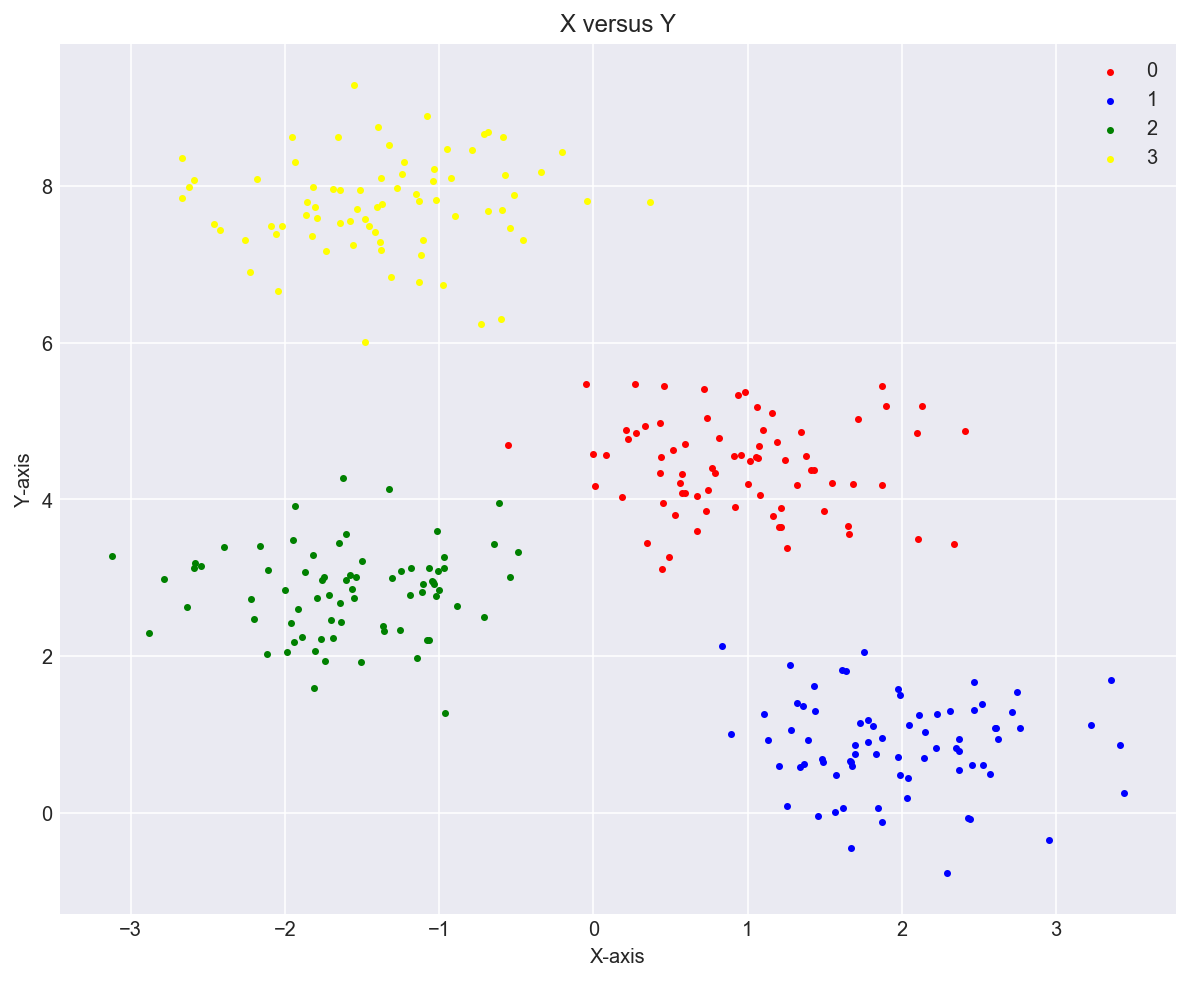

In [4]:
plot(X, y_true)

## K-means Clustering

In [5]:
class K_means:

    __slots = ['n_clusters', 'random_seed', 'centers', 'X_labelled']

    def __init__(self, n_clusters: int, random_seed: int = 2):
        """
        The n_clusters is the k value
        X_labelled represents the labels of the points in X feat
        """
        self.n_clusters = n_clusters
        self.random_seed = random_seed
        self.centers = None
        self.X_labelled = None

    def fit(self, X, centers=None):
        """
        The centers var must an array of numpy.ndarrays of R dimensions
        i.e. centers = [array([2., 2.]),
                        array([1., 1.])]
        """
        if centers is None:
            m, n = X.shape
            r_state = np.random.RandomState(self.random_seed)
            centers_idx = r_state.permutation(m)[:self.n_clusters]
            self.centers = np.take(X, centers_idx, axis=0)
        else:
            self.centers = np.array(centers)

        # Repeat recalculation of centers until convergance
        while True:
            # points labelled based on closest centers using euclidean distance
            self.X_labelled = pairwise_distances_argmin(
                X, self.centers, axis=1, metric='euclidean')

            #  Find new centers from means of points:
            #  Update centroid of each cluster to be the average(mean) of examples assigned to cluster k
            updated_centers = [np.take(
                X, np.where(self.X_labelled == i), axis=0).mean(axis=1)[0]
                for i in range(self.n_clusters)]

            #  check for convergence
            check = [1 for c_old, c_new in zip(self.centers, updated_centers)
                     if np.isclose(c_old[0], c_new[0]) and np.isclose(c_old[1], c_new[1])]

            if len(check) == self.n_clusters:
                break
            self.centers = updated_centers

### K means clustering with a random seed of 0

The new centroid coordinates  are [array([-1.37324398,  7.75368871]), array([1.95636329, 1.46879371]), array([-0.35164179,  3.62712721]), array([2.01881381, 0.44148546])]


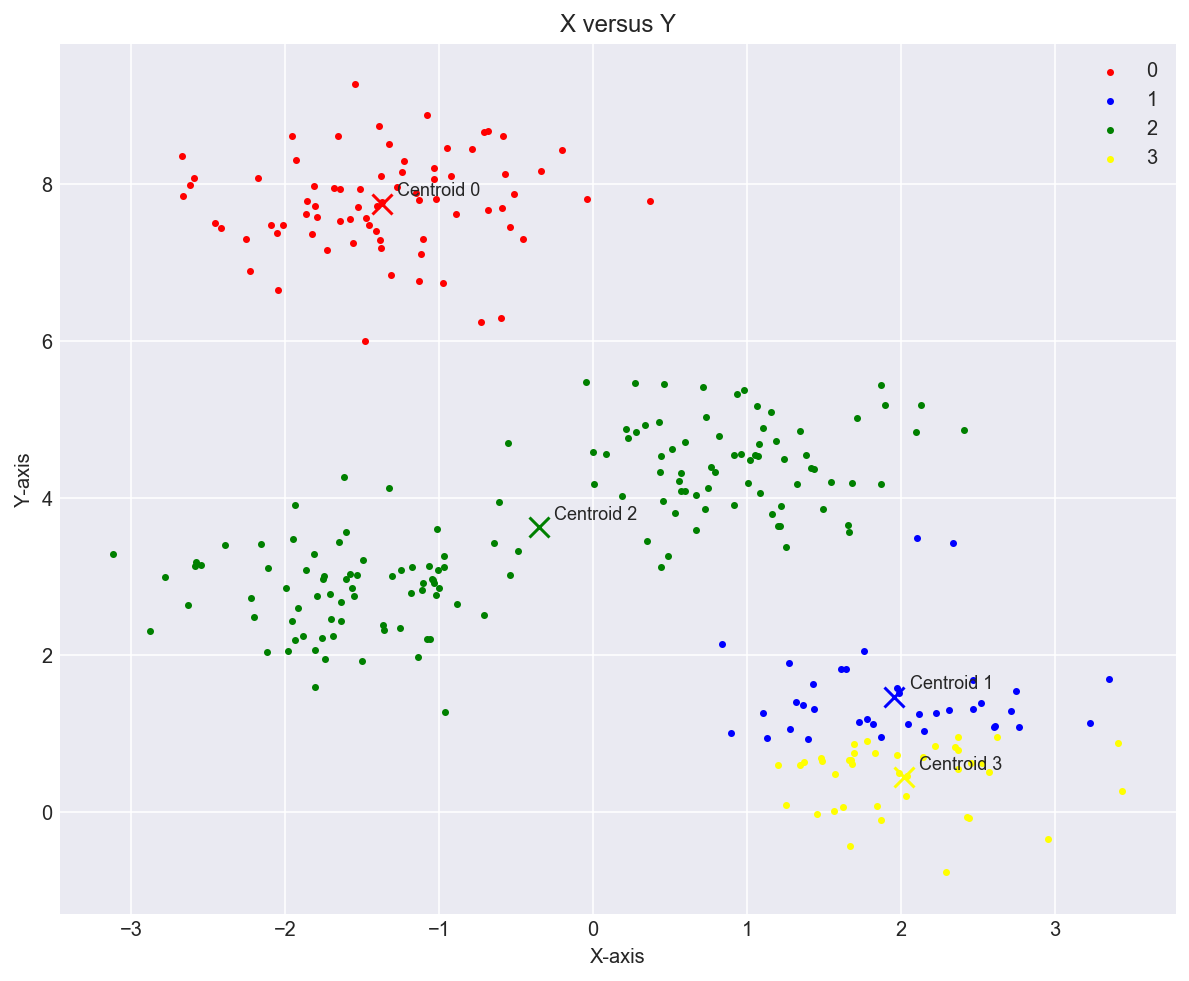

In [6]:
k_means = K_means(4, 0)
k_means.fit(X)

print(f"The new centroid coordinates  are {k_means.centers}")
plot(X, k_means.X_labelled, centers=k_means.centers)

### K means clustering with a random seed of 2

The new centroid coordinates  are [array([0.94973532, 4.41906906]), array([-1.37324398,  7.75368871]), array([1.98258281, 0.86771314]), array([-1.58438467,  2.83081263])]


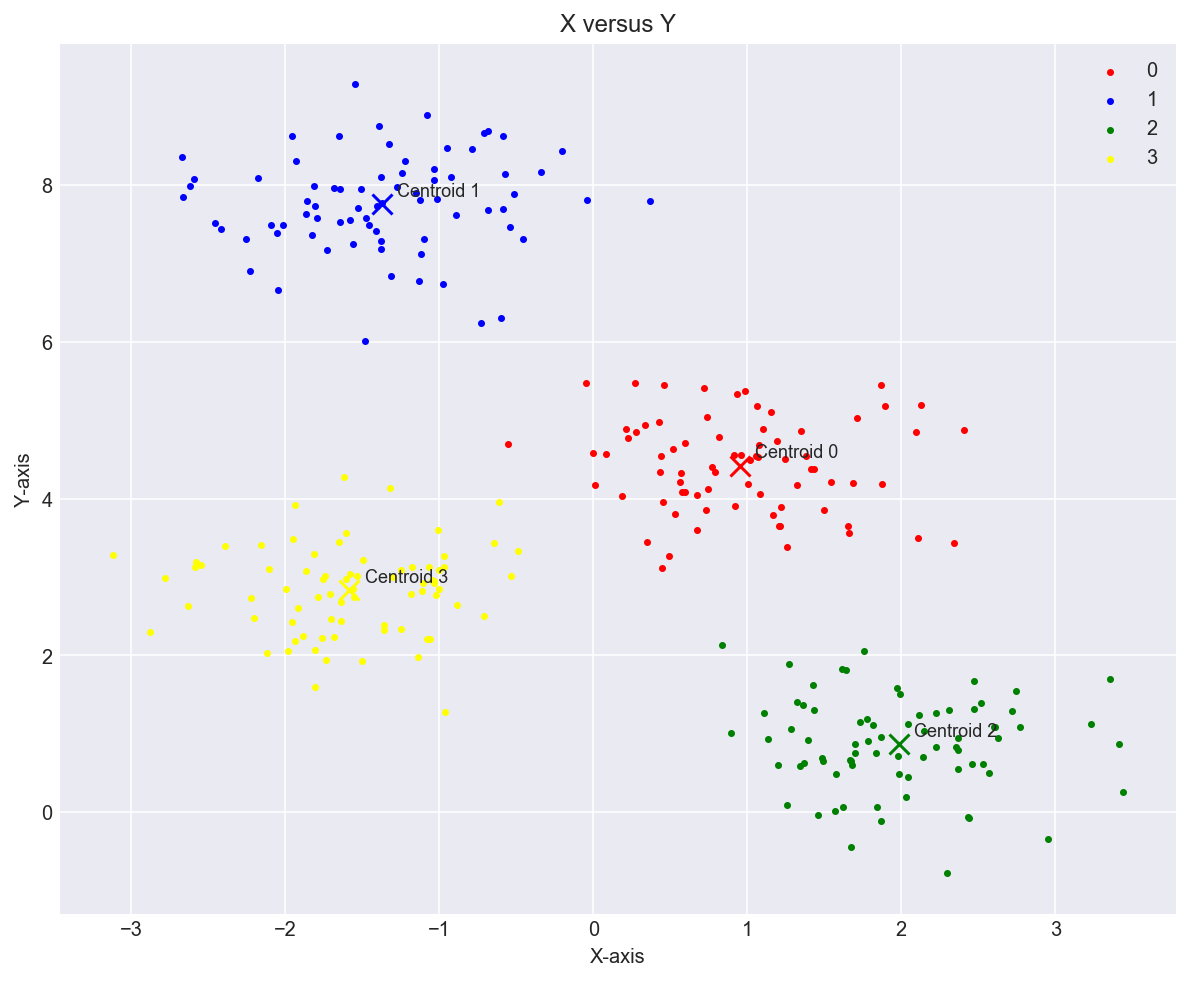

In [7]:
k_means = K_means(4, 2)
k_means.fit(X)

print(f"The new centroid coordinates  are {k_means.centers}")
plot(X, k_means.X_labelled, centers=k_means.centers)

With the default K-means clustering algorithm, we observe that with a seed of 0, the clustering algorithm does not perform well. Due to random chance, the initial clusters were chosen at such a location which caused the clustering algorithm to converge to suboptimal centroids as seen in the figure with a seed of 0.

## K-Means ++ Centroid selection and Clustering

In [8]:
def eucledian_dist(x0, x1):
    """
    Returns the euclidean distance as vectors.
    x0, x1 must be 2D numpy.ndarray
    """
    return np.sqrt(np.sum((x1-x0)**2, axis=1))


class K_means_plus_plus(K_means):

    __slots__ = ['n_clusters', 'random_seed', 'centers', 'X_labelled']

    def __init__(self, n_clusters: int, random_seed: int = 2):
        super().__init__(n_clusters, random_seed)

    def init_centers(self, X):
        """
        K means ++ center selection algorithm
        """
        # Randomly shuffle array and set the first elem as the first center
        m, n = X.shape
        r_state = np.random.RandomState(self.random_seed)
        self.centers = np.take(X, [r_state.permutation(m)[0]], axis=0)
        self.centers = np.concatenate((self.centers, np.array([[1.2, 2.3]])))
        
        while len(self.centers) < self.n_clusters:
            closest_center_labels = pairwise_distances_argmin(
                X, self.centers, axis=1, metric='euclidean')
            
            # stores the dist of the closest center for each point
            dist_closest_centers = np.array([eucledian_dist(self.centers[closest_center_labels[i]],[coord]) 
                                    for i,coord in enumerate(X)])
            dist_closest_centers **= 2
            total_sum = np.sum(dist_closest_centers)
            prob_closest_centers = dist_closest_centers/total_sum
            prob_closest_centers = prob_closest_centers.ravel()
            
            next_center_idx = np.random.choice(m, 1, p=prob_closest_centers)
            self.centers = np.concatenate((self.centers, X[next_center_idx]))

### K means plus plus clustering with a random seed of 2

The new centroid coordinates  are [array([0.94973532, 4.41906906]), array([1.98258281, 0.86771314]), array([-1.58438467,  2.83081263]), array([-1.37324398,  7.75368871])]


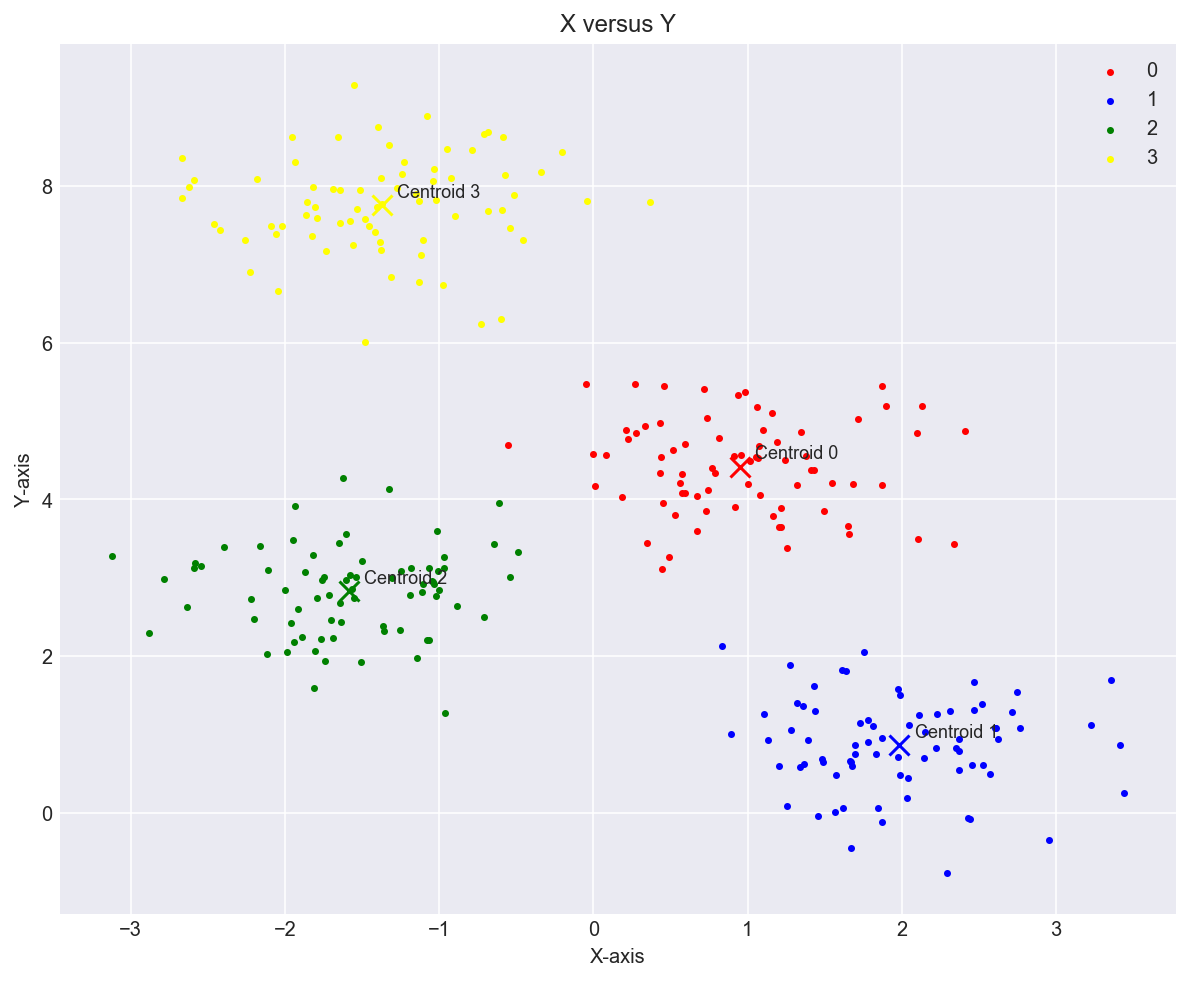

In [9]:
Xs = K_means_plus_plus(4, 2)
Xs.init_centers(X)
Xs.fit(X, centers=Xs.centers)

print(f"The new centroid coordinates  are {Xs.centers}")
plot(X, Xs.X_labelled, centers=Xs.centers)

### K means plus plus clustering with a random seed of 0

The new centroid coordinates  are [array([0.94973532, 4.41906906]), array([1.98258281, 0.86771314]), array([-1.37324398,  7.75368871]), array([-1.58438467,  2.83081263])]


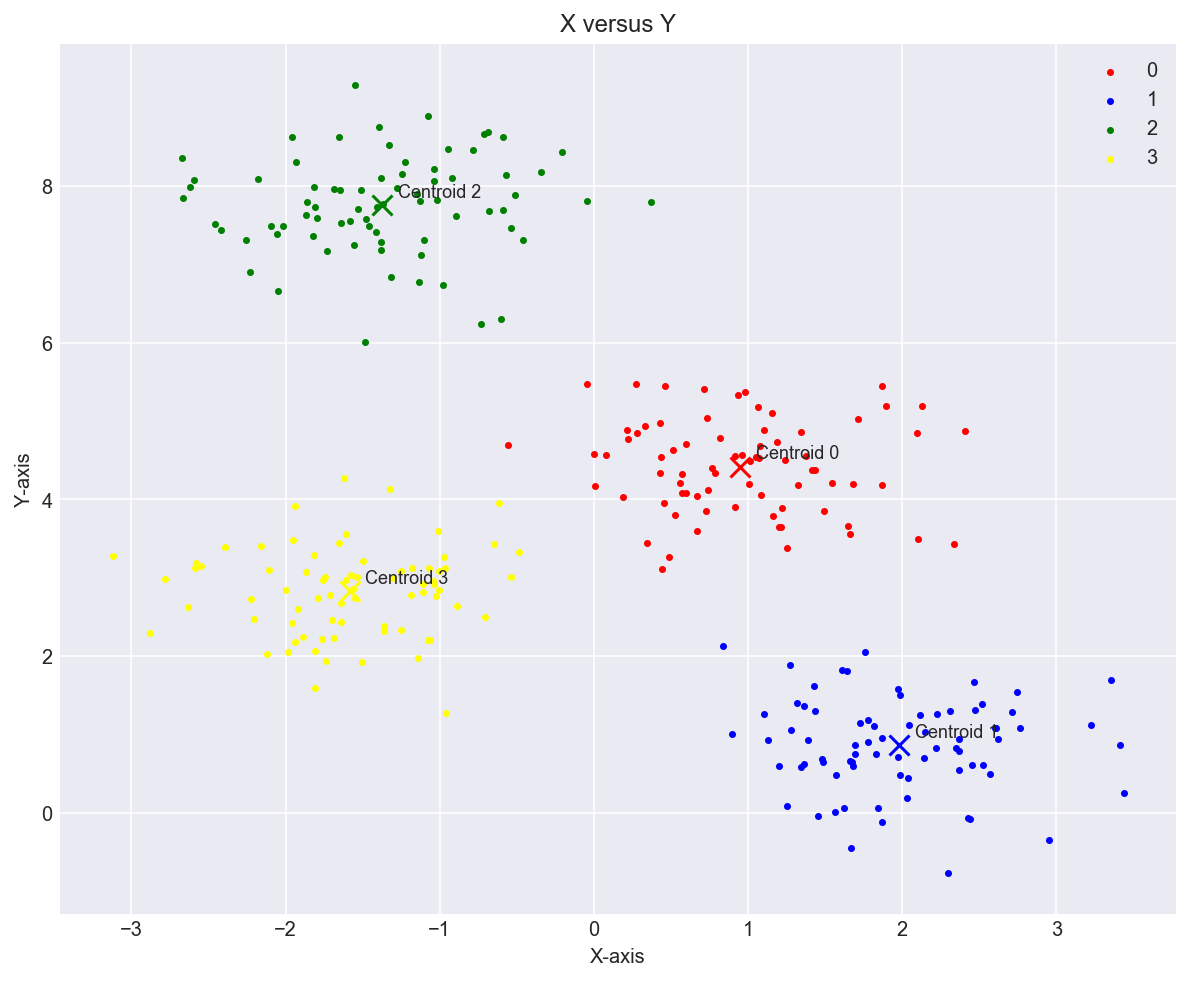

In [10]:
kplus = K_means_plus_plus(4, 0)
kplus.init_centers(X)
kplus.fit(X, centers=kplus.centers)

print(f"The new centroid coordinates  are {kplus.centers}")
plot(X, kplus.X_labelled, centers=kplus.centers)

Now with the improved K-means plus plus centroid selection and clustering algorithm, regardless of the seed value, the clustering algorithm performs well because as the initial clusters were chosen to be as far apart as possible to increase the chances of an optimal cluster formation as seen in the figures above.

Overall, the k-means clustering algorithm should not be used by itself as deduced from our results but instead should be used with the k-means plus plus centroid selection algorithm.